In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('E:\EEP595EnronEmailProject\emails'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

E:\EEP595EnronEmailProject\emails\emails.csv


In [9]:
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session

In [10]:
# load Google's pre-trained word2vec embeddings
# filename = "/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"
filename = ".\GoogleNews-vectors-negative300.bin"

start = time.time()
google_embeddings = KeyedVectors.load_word2vec_format(filename, binary=True)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  160.07946300506592


In [11]:
# load Stanford's pre-trained GloVe embeddings
# glove_file = "/kaggle/input/glove-embeddings/glove.6B.300d.txt"
glove_file = ".\glove.6B.300d.txt"
glove_word2vec_file = "glove.6B.100d.txt.word2vec"

glove2word2vec(glove_file, glove_word2vec_file)

(400000, 300)

In [12]:
# glove embeddings
start = time.time()

glove_embeddings = KeyedVectors.load_word2vec_format(glove_word2vec_file, binary=False)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  136.82092261314392


In [13]:
# load data
data = pd.read_csv(".\preprocessed.csv")

# view first 5 rows of the dataframe 'data'
data.head()

,X-Folder,text
0,california,caiso notice summer 2001 generation rfb market...
1,california,ca iso cal px information related 2000 market ...
2,california,caiso notification update inter sc trades adju...
3,california,update mif meeting presentations iso website u...
4,california,mif presentations presentations market issues ...


In [14]:
# shape of the data
data.shape

(13586, 2)

In [15]:
# count number of instances in each folder
data['X-Folder'].unique()

array(['california', 'calendar', 'resumes', 'archives', 'junk file',
       'ces', 'logistics', 'tufco', 'projects', 'online trading',
       'management', 'esvl', 'ooc', 'corporate', 'tw-commercial group',
       'genco-jv_ipo', 'junk', 'deal discrepancies', 'e-mail bin',
       'bill williams iii'], dtype=object)

In [16]:
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'X-Folder' column
    y = class_le.fit_transform(data['X-Folder'])
    return y

In [17]:
y = label_encoder(data)
input_data = data['text']

In [18]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(input_data, y, test_size=0.1)

In [19]:
# one-hot encode the output labels
Y_train = to_categorical(y_train, 20)
Y_test = to_categorical(y_test, 20)

In [20]:
# prepare tokenizer
t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(input_data)
vocab_size = len(t.word_index) + 1

# integer encode the documents
X_train_encoded_docs = t.texts_to_sequences(X_train)
X_test_encoded_docs = t.texts_to_sequences(X_test)

In [21]:
# pad documents to a max length of 150 words
max_length = 150
X_train_padded_docs = pad_sequences(X_train_encoded_docs, maxlen=max_length, padding='post')
X_test_padded_docs = pad_sequences(X_test_encoded_docs, maxlen=max_length, padding='post')

print(X_train_padded_docs[0])

[  378  1182   875  2586 53688    14    13  1912  1582   952    48   120
  3565   292    35   450   342  2627   293  2168    35   896   491  3496
    27  3707 33694  1261  2801   628   924   242   172  1536  1234   120
   266  1293   334   338   172   491    42  2168    48    41  2351   395
   266  1759  2612  1457   618  2064  5072  1700    36  1917  1642   699
   395   266   293  4769  1800   334  1234   395   266  1156   830   699
   746  4301    35  9434   107   628  4597  3955   796  1234   266   395
    13   699   162  1554   619  2109   763   107   322  4803    13   162
    65   155 53689  2015  4568  2015   162  3375   266  1088  1290 25433
   241  1575  1020   595   582    14   297  2202  3955  1611  1170   619
   753   753 53690  1913   252   247  2301  8200   695 11574  9386  6848
  4398 53691  8150 17664 27809   283   237   753 16925     3    12    22
 16925     3    12    22 16925     3]


In [22]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = google_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [23]:
# define the model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100, dropout=0.2))
model.add(Flatten())
model.add(Dense(20, activation='softmax'))


# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          17877600  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
Total params: 18,040,020
Trainable params: 162,420
Non-trainable params: 17,877,600
_________________________________________________________________


In [24]:
clear_session()

In [25]:
# train the model
clear_session()
history = model.fit(X_train_padded_docs, Y_train, epochs=60, verbose=1, validation_split=0.1)

Epoch 1/60
344/344 [==============================] - 61s 144ms/step - loss: 2.8982 - accuracy: 0.1110 - val_loss: 2.7494 - val_accuracy: 0.1701
Epoch 2/60
344/344 [==============================] - 43s 124ms/step - loss: 2.7405 - accuracy: 0.1672 - val_loss: 3.2564 - val_accuracy: 0.1047
Epoch 3/60
344/344 [==============================] - 44s 127ms/step - loss: 2.8733 - accuracy: 0.1269 - val_loss: 2.8401 - val_accuracy: 0.1284
Epoch 4/60
344/344 [==============================] - 44s 127ms/step - loss: 2.7821 - accuracy: 0.1473 - val_loss: 2.8188 - val_accuracy: 0.1333
Epoch 5/60
344/344 [==============================] - 44s 127ms/step - loss: 2.6886 - accuracy: 0.1851 - val_loss: 2.7470 - val_accuracy: 0.2142
Epoch 6/60
344/344 [==============================] - 44s 127ms/step - loss: 2.7864 - accuracy: 0.1621 - val_loss: 2.8317 - val_accuracy: 0.1145
Epoch 7/60
344/344 [==============================] - 44s 127ms/step - loss: 2.7456 - accuracy: 0.1698 - val_loss: 2.8102 - val_ac

344/344 [==============================] - 70s 204ms/step - loss: 0.1617 - accuracy: 0.9428 - val_loss: 1.2170 - val_accuracy: 0.7179
Epoch 58/60
344/344 [==============================] - 63s 183ms/step - loss: 0.1678 - accuracy: 0.9378 - val_loss: 1.2005 - val_accuracy: 0.7187
Epoch 59/60
344/344 [==============================] - 69s 200ms/step - loss: 0.1649 - accuracy: 0.9412 - val_loss: 1.2335 - val_accuracy: 0.7236
Epoch 60/60
344/344 [==============================] - 71s 208ms/step - loss: 0.1571 - accuracy: 0.9436 - val_loss: 1.2451 - val_accuracy: 0.7277


In [26]:
# evaluate the model on the test set
accr = model.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr[0], accr[1]))

43/43 [==============================] - 3s 67ms/step - loss: 1.2645 - accuracy: 0.7219
Test Set: 
 Loss: 1.264
 Accuracy: 0.722


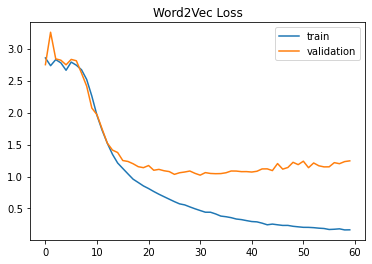

In [27]:
# plot the loss
plt.title("Word2Vec Loss")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

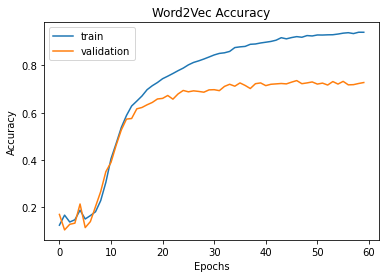

In [28]:
# plot the accuracy
plt.title("Word2Vec Accuracy")
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

In [29]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = glove_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [30]:
# define the model
model2 = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model2.add(e)
model2.add(LSTM(100, dropout=0.2))
model2.add(Flatten())
model2.add(Dense(20, activation='softmax'))


# compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          17877600  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
Total params: 18,040,020
Trainable params: 162,420
Non-trainable params: 17,877,600
_________________________________________________________________


In [31]:
# fit the model
history2 = model2.fit(X_train_padded_docs, Y_train, epochs=60, verbose=1, validation_split=0.1)

Epoch 1/60
344/344 [==============================] - 81s 216ms/step - loss: 2.8582 - accuracy: 0.1199 - val_loss: 2.6643 - val_accuracy: 0.1521
Epoch 2/60
344/344 [==============================] - 68s 198ms/step - loss: 2.5973 - accuracy: 0.2088 - val_loss: 2.7743 - val_accuracy: 0.1611
Epoch 3/60
344/344 [==============================] - 76s 220ms/step - loss: 2.5833 - accuracy: 0.2143 - val_loss: 2.4477 - val_accuracy: 0.2478
Epoch 4/60
344/344 [==============================] - 73s 214ms/step - loss: 2.4674 - accuracy: 0.2455 - val_loss: 2.4358 - val_accuracy: 0.2347
Epoch 5/60
344/344 [==============================] - 79s 228ms/step - loss: 2.4066 - accuracy: 0.2567 - val_loss: 2.5777 - val_accuracy: 0.1856
Epoch 6/60
344/344 [==============================] - 77s 224ms/step - loss: 2.3955 - accuracy: 0.2570 - val_loss: 2.3550 - val_accuracy: 0.2633
Epoch 7/60
344/344 [==============================] - 78s 227ms/step - loss: 2.2677 - accuracy: 0.2925 - val_loss: 2.3323 - val_ac

344/344 [==============================] - 77s 223ms/step - loss: 0.1274 - accuracy: 0.9517 - val_loss: 1.1977 - val_accuracy: 0.7547
Epoch 58/60
344/344 [==============================] - 75s 220ms/step - loss: 0.1278 - accuracy: 0.9520 - val_loss: 1.1683 - val_accuracy: 0.7522
Epoch 59/60
344/344 [==============================] - 73s 213ms/step - loss: 0.1187 - accuracy: 0.9564 - val_loss: 1.2321 - val_accuracy: 0.7482
Epoch 60/60
344/344 [==============================] - 64s 185ms/step - loss: 0.1337 - accuracy: 0.9499 - val_loss: 1.2019 - val_accuracy: 0.7531


In [32]:
# evaluate the model2 on the test set
accr2 = model2.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr2[0], accr2[1]))

43/43 [==============================] - 2s 42ms/step - loss: 1.2158 - accuracy: 0.7476
Test Set: 
 Loss: 1.216
 Accuracy: 0.748


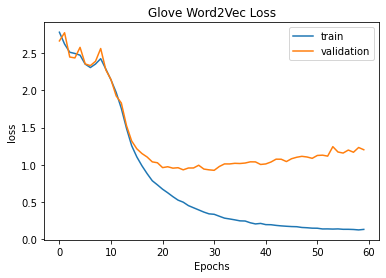

In [33]:
# plot the loss
plt.title("Glove Word2Vec Loss")
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

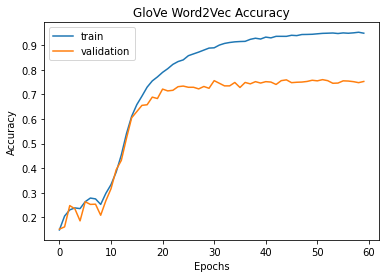

In [34]:
# plot the accuracy
plt.title("GloVe Word2Vec Accuracy")
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

In [35]:
# define the model
model3 = Sequential()
model3.add(Embedding(vocab_size, 300, input_length=max_length))
model3.add(LSTM(100, dropout=0.4))
model3.add(Flatten())
model3.add(Dense(20, activation='softmax'))

# compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          17877600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
Total params: 18,040,020
Trainable params: 18,040,020
Non-trainable params: 0
_________________________________________________________________


In [36]:
# train the model
history3 = model3.fit(X_train_padded_docs, Y_train, validation_split=0.1, epochs=20, verbose=1)

Epoch 1/20
344/344 [==============================] - 221s 624ms/step - loss: 2.9038 - accuracy: 0.1170 - val_loss: 2.7291 - val_accuracy: 0.1545
Epoch 2/20
344/344 [==============================] - 229s 666ms/step - loss: 2.6553 - accuracy: 0.1826 - val_loss: 2.5602 - val_accuracy: 0.2011
Epoch 3/20
344/344 [==============================] - 238s 693ms/step - loss: 2.4880 - accuracy: 0.2469 - val_loss: 2.4063 - val_accuracy: 0.2461
Epoch 4/20
344/344 [==============================] - 233s 678ms/step - loss: 2.2257 - accuracy: 0.3359 - val_loss: 2.3030 - val_accuracy: 0.3295
Epoch 5/20
344/344 [==============================] - 233s 677ms/step - loss: 1.9052 - accuracy: 0.4217 - val_loss: 1.9524 - val_accuracy: 0.4031
Epoch 6/20
344/344 [==============================] - 227s 661ms/step - loss: 1.8359 - accuracy: 0.4362 - val_loss: 1.9063 - val_accuracy: 0.4227
Epoch 7/20
344/344 [==============================] - 256s 743ms/step - loss: 1.6388 - accuracy: 0.4869 - val_loss: 1.7483 -

In [37]:
# save learned word embeddings
own_embeddings = model3.get_layer('embedding_1').get_weights()[0]

custom_w2v = {}

for word, index in t.word_index.items():
    custom_w2v[word] = own_embeddings[index]
    
import pickle    
# save to file
with open("own_embeddings.pkl", "wb") as handle:
    pickle.dump(custom_w2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
# load own_embeddings
#with open("own_embeddings.pkl", "rb") as handle:
 #   own_embeddings = pickle.load(handle)

In [39]:
# evaluate the model
accr3 = model3.evaluate(X_test_padded_docs, Y_test)

print("Test Set:\n  Loss: {:0.3f}\n   Accuracy: {:0.3f}".format(accr3[0], accr3[1]))

43/43 [==============================] - 3s 79ms/step - loss: 1.2080 - accuracy: 0.7417
Test Set:
  Loss: 1.208
   Accuracy: 0.742


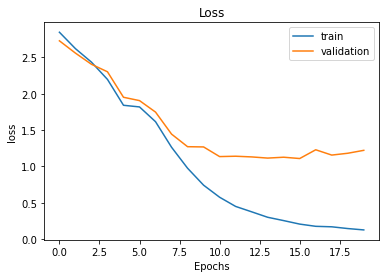

In [40]:
# plot the loss
plt.title("Loss")
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

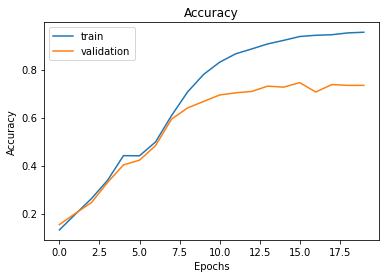

In [41]:
# plot the accuracy
plt.title("Accuracy")
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

In [42]:
# create a dataframe to store results
res_data = {
    "Technique": ['Word2Vec', 'GloVe', 'Training data Embeddings'],
    "test accuracy": [accr[1], accr2[1], accr3[1]]
}
result = pd.DataFrame(res_data)
result

,Technique,test accuracy
0,Word2Vec,0.721854
1,GloVe,0.747609
2,Training data Embeddings,0.741722


In [43]:
data.shape

(13586, 2)